In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

## The original data

We first read original data

(The data used in this notebook have been uploaded here https://www.kaggle.com/elmahy/pems-dataset)

Its shape is # (sequence_length, num_of_vertices, num_of_features) (16992, 307, 3)

We have 307 detectors each detector detect three features such as speed of cars, congestion,etc.
And we store that data every five minutes.
In 5 mins, our data will be (1, 307, 3)
In 1 hour ,  our data will be (12, 307, 3)
In 1 day ,our data will be (12 * 24, 307, 3)
In 59 days, our data will be (12 * 24 * 59, 307, 3) =  (16992, 307, 3)

### .npz数据集记录了有关传感器站的地理信息。

在我们的实验中考虑了三种流量测量，包括总流量、平均速度和平均占用率。

这些测量值每 5 分钟记录一次，因此每小时有 12 个数据点，每天有 288 个数据点。在整个数据集中，每个传感器站有 16992 个数据点。

### .csv from,to,cost 表示从一个节点到另一个节点的距离。





In our example we sample data per hour, so ignore anything about weeks or days

Each hour's data is used to predict the next hour's data

the 1 hour data(INPUT) is of shape (12, 307, 3) and the next hour(TARGET) is the same  (12, 307, 3)

The functions get_sample_indices and search_data simply finds the input and the target since the orininal data have 16992 points collected every 5 minutes


for example,
the first 12 points(0:12) will be extracted from original data have 16992 points i.e. original[0:12]
The target is the next hour so it will  be the next 12 points(12:24) i.g. original[12:24]

Cool ... generate more .. move 5 minutes in the future ....

the first 12 points(1:13) will be extracted from original data have 16992 points i.e. original[1:13]
The target is the next hour so it will  be the next 12 points(13:25) i.g. original[13:25]


And sooooo on.

How many INPUT data and TARGET examples do we have now ?
We havee 16969 examples which is 16992 (original) - 23

The missing 23 points are the first 11 points(first hour) in the original sequence and the last 12 points(last hour) in the sequence i.e. the first hour data can't be predicted from any other previous data and the last hour data can't be used for predicting any future data because it's the last one in the training. So we ingore both.

## Data splitting

10181 data/target examples will be used as the training set ( 35 days )

3394 data/target examples will be used as the validation set (12 days)

3394 data/target examples will be used as the testing set (12 days)


In [10]:
# search_data 旨在从时间序列数据中提取一组索引对，用于预测模型的输入。它通过指定的历史依赖关系（num_of_depend）和其他参数来确定这些索引对。
def search_data(sequence_length, num_of_depend, label_start_idx, num_for_predict, units, points_per_hour):
    """
    Parameters
    ----------
    sequence_length: int, length of all history data
    num_of_depend: int,
    label_start_idx: int, the first index of predicting target
    num_for_predict: int, the number of points will be predicted for each sample
    units: int, week: 7 * 24, day: 24, recent(hour): 1
    points_per_hour: int, number of points per hour, depends on data
    Returns
    ----------
    list[(start_idx, end_idx)]
    """

    if points_per_hour < 0:
        raise ValueError("points_per_hour should be greater than 0!")

    if label_start_idx + num_for_predict > sequence_length:
        return None

    x_idx = []
    for i in range(1, num_of_depend + 1):
        start_idx = label_start_idx - points_per_hour * units * i
        end_idx = start_idx + num_for_predict
        if start_idx >= 0:
            x_idx.append((start_idx, end_idx))
        else:
            return None

    if len(x_idx) != num_of_depend:
        return None
    # 返回索引对列表的逆序版本。这样可以确保最早的依赖在列表的最前面。
    # x_idx[::-1] 等价于 x_idx[None:None:-1]，表示从列表的末尾开始，以步长 -1 逐步向前，直到列表的开头。
    return x_idx[::-1]

In [11]:
# get_sample_indices 旨在从时间序列数据中提取样本，用于预测模型的输入。它根据指定的周、天和小时的依赖关系，返回相应的样本和预测目标。
def get_sample_indices(data_sequence, num_of_weeks, num_of_days, num_of_hours, label_start_idx, num_for_predict,
                       points_per_hour=12):
    '''
    Parameters
    ----------
    data_sequence: np.ndarray shape is (sequence_length, num_of_vertices, num_of_features)
    num_of_weeks, num_of_days, num_of_hours: int
    label_start_idx: int, the first index of predicting target
    num_for_predict: int,the number of points will be predicted for each sample
    points_per_hour: int, default 12, number of points per hour
    Returns
    ----------
    week_sample: np.ndarray shape is (num_of_weeks * points_per_hour, num_of_vertices, num_of_features)
    day_sample: np.ndarray shape is (num_of_days * points_per_hour,  num_of_vertices, num_of_features)
    hour_sample: np.ndarray   shape is (num_of_hours * points_per_hour, num_of_vertices, num_of_features)
    target: np.ndarray shape is (num_for_predict, num_of_vertices, num_of_features)
    '''
    week_sample, day_sample, hour_sample = None, None, None
    #------------------------------------Ignore
    # 检查预测的结束索引是否超出了数据序列的长度。如果超出，返回 None。
    if label_start_idx + num_for_predict > data_sequence.shape[0]:
        return week_sample, day_sample, hour_sample, None

    if num_of_hours > 0:
        hour_indices = search_data(data_sequence.shape[0], num_of_hours, label_start_idx, num_for_predict, 1, points_per_hour)
        if not hour_indices:
            return None, None, None, None
        hour_sample = np.concatenate([data_sequence[i: j] for i, j in hour_indices], axis=0)
        print('hour_indices：', hour_indices)

    if num_of_hours > 10:
        return 1;
    # 提取预测目标
    target = data_sequence[label_start_idx: label_start_idx + num_for_predict]

    return week_sample, day_sample, hour_sample, target

### Q:  TensorDataset 是PyTorch中的数据集类，用于将多个张量组合成一个数据集。每个样本由输入张量和目标张量组成。 这里为什么要将数据集分成输入张量和目标张量？

```
training_set = [np.concatenate(i, axis=0)  for i in zip(*all_samples[:split_line1])] #[(B,N,F,Th),(B,N,Tpre),(B,1)]
```
A:
**1. 监督学习的需求**

监督学习任务的核心是学习从输入特征到目标标签的映射关系。为了实现这一点，模型需要一组输入特征（输入张量）和对应的目标标签（目标张量）来进行训练。输入张量提供了模型的输入数据，而目标张量提供了模型需要预测的目标。


**2. 数据加载和批处理**

将数据集分成输入张量和目标张量，可以方便地使用 PyTorch 的 DataLoader 类进行数据加载和批处理。DataLoader 可以自动将数据集分成小批量（mini-batches）进行训练，从而提高训练效率和稳定性。


**3. 数据预处理和增强**

在训练过程中，输入张量和目标张量可能需要不同的预处理和数据增强操作。例如，输入图像可能需要进行归一化、随机裁剪等操作，而目标标签则不需要这些操作。将它们分开处理可以简化数据预处理流程。


**4. 模型评估和调试**

在模型评估和调试过程中，分开处理输入张量和目标张量可以更容易地计算各种评估指标（如准确率、损失等），以及进行调试和错误分析。

In [12]:
# 从图信号矩阵文件中读取数据，并生成用于训练、验证和测试的数据集。
def read_and_generate_dataset(graph_signal_matrix_filename, num_of_weeks, num_of_days, num_of_hours, num_for_predict,
                              points_per_hour=12):
    '''
    Parameters
    ----------
    graph_signal_matrix_filename: str, path of graph signal matrix file
    num_of_weeks, num_of_days, num_of_hours: int
    num_for_predict: int
    points_per_hour: int, default 12, depends on data
    Returns
    ----------
    feature: np.ndarray, shape is (num_of_samples, num_of_depend * points_per_hour, num_of_vertices, num_of_features)
    target: np.ndarray, shape is (num_of_samples, num_of_vertices, num_for_predict)
    '''
    #--------------------------------- Read original data
    data_seq = np.load(graph_signal_matrix_filename)['data']  # (sequence_length, num_of_vertices, num_of_features) (16992, 307, 3)

    #---------------------------------
    all_samples = []
    print('data_seq.shape[0]', data_seq.shape[0]) # 16992
    for idx in range(data_seq.shape[0]):
        sample = get_sample_indices(data_seq, num_of_weeks, num_of_days, num_of_hours, idx, num_for_predict,points_per_hour)
        if (sample[0] is None) and (sample[1] is None) and (sample[2] is None):
            continue

        week_sample, day_sample, hour_sample, target = sample  #  week_sample, day_sample are None because we are predicting per hour
        print(target.shape)  # hour_sample and target (12, 307, 3)
        sample = []  # [(week_sample),(day_sample),(hour_sample),target,time_sample]

        if num_of_hours > 0:
            hour_sample = np.expand_dims(hour_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(hour_sample)

        # [:, :, 0, :] 第二个轴选择0个元素==>>切片操作后，形状将从 (1, N, F, T) 变为 (1, N, T)
        target = np.expand_dims(target, axis=0).transpose((0, 2, 3, 1))[:, :, 0, :]  # (1,N,T)
        sample.append(target)
        # 创建一个包含当前索引的时间样本，并添加到 sample 列表中
        time_sample = np.expand_dims(np.array([idx]), axis=0)  # (1,1)
        sample.append(time_sample)
        all_samples.append(
            sample)  #sampe：[(week_sample),(day_sample),(hour_sample),target,time_sample] = [(1,N,F,Tw),(1,N,F,Td),(1,N,F,Th),(1,N,Tpre),(1,1)]

    # 按比例将 all_samples 划分为训练集（60%）、验证集（20%）和测试集（20%）。使用 zip 和 np.concatenate 将样本拼接成一个数组。
    split_line1 = int(len(all_samples) * 0.6)
    split_line2 = int(len(all_samples) * 0.8)

    # zip 函数用于将多个可迭代对象打包成一个元组的迭代器。*subset_samples 表示对 subset_samples 进行解包操作。
    training_set = [np.concatenate(i, axis=0) for i in
                    zip(*all_samples[:split_line1])]  #[(B,N,F,Tw),(B,N,F,Td),(B,N,F,Th),(B,N,Tpre),(B,1)]
    validation_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line1: split_line2])]
    testing_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line2:])]

    """
    zipped_samples = zip(*subset_samples)
    结果是一个迭代器，内容如下：
    [
      (array1_1, array1_2, ..., array1_10),
      (array2_1, array2_2, ..., array2_10),
      (array3_1, array3_2, ..., array3_10),
      (array4_1, array4_2, ..., array4_10),
      (array5_1, array5_2, ..., array5_10)
    ]

    np.concatenate 后 training_set 中每个数组的形状：(B * split_line1, N, F, T)
    """

    return training_set, validation_set, testing_set

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/pytorch_geometric_temporal/notebooks')

Keys in the .npz file: ['data']
Array name: data
Shape: (16992, 307, 3)
Data type: float64

(16992,)


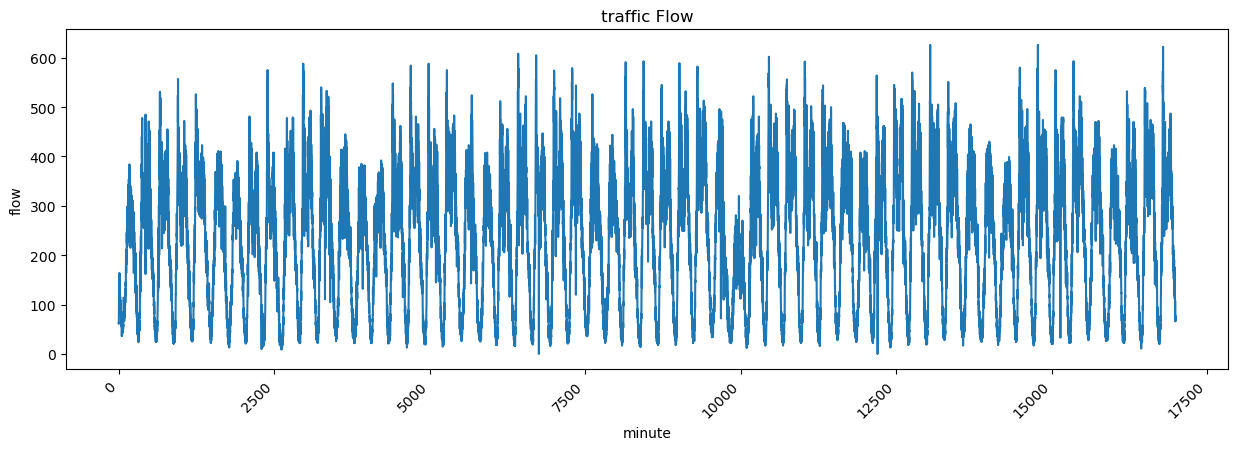

(16992,)


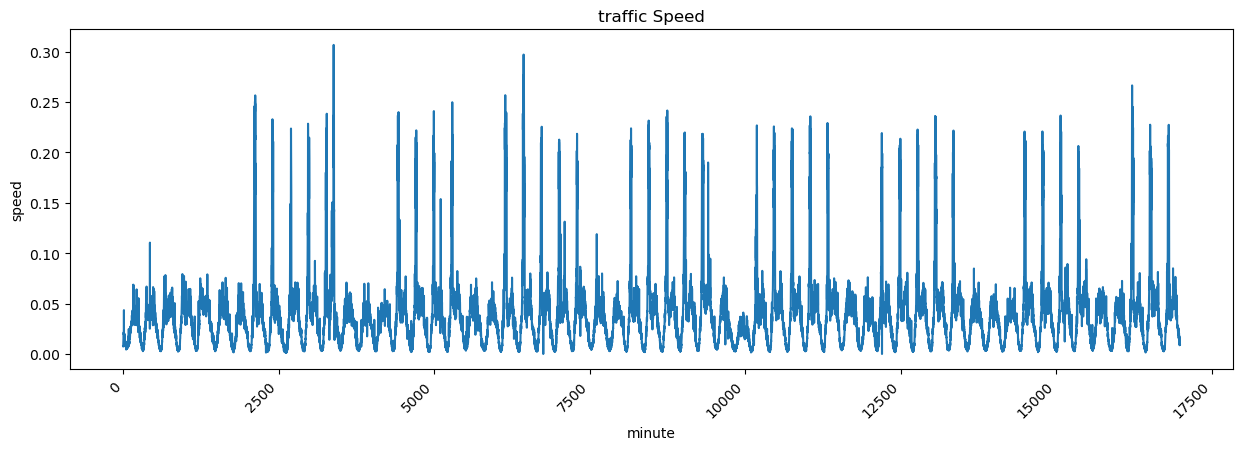

(16992,)


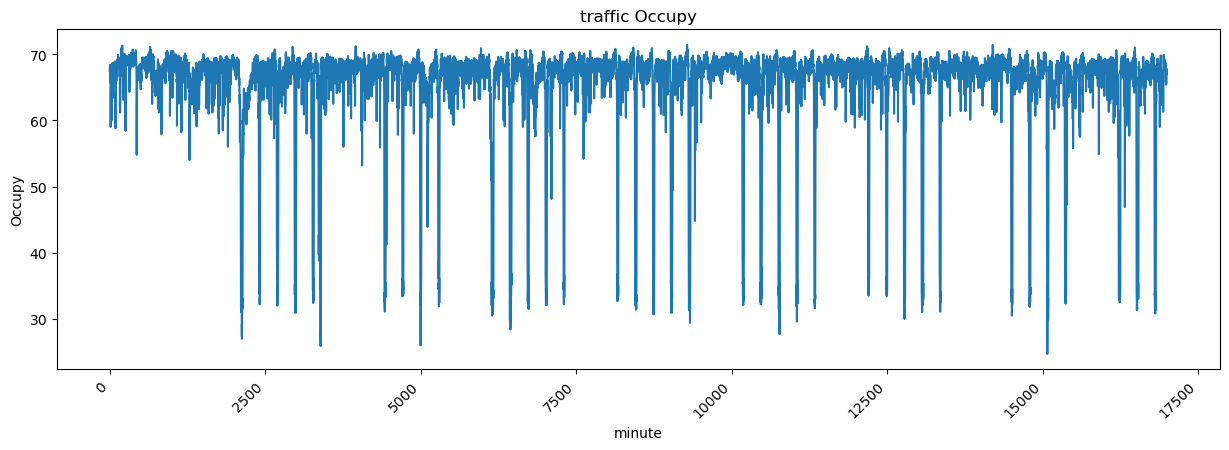

In [13]:
graph_signal_matrix_filename = './data/pems-dataset/PEMS04/PEMS04.npz'
data = np.load(graph_signal_matrix_filename)

# 查看文件中的键
print("Keys in the .npz file:", data.files)
# 查看每个数组的形状和数据类型
for key in data.files:
    array = data[key]
    print(f"Array name: {key}")
    print(f"Shape: {array.shape}")  # (16992, 307, 3) 16992=59天*24小时*12(每五分钟采集一次数据)，307为节点数量，3为特征数量
    # 特征：交通流量，平均速度，平均占用率
    print(f"Data type: {array.dtype}")
    # print(array[:5])
    print()

# import matplotlib.pyplot as plt
# 
# flow = data['data'][:, 0, 0]  # (16992, 307)
# print(flow.shape)
# fig_flow = plt.figure(figsize=(15, 5))
# plt.title('traffic Flow')
# plt.xlabel('minute')
# plt.ylabel('flow')
# plt.plot(np.arange(len(flow)), flow, linestyle='-')
# fig_flow.autofmt_xdate(rotation=45)
# plt.show()
# 
# speed = data['data'][:, 0, 1]  # (16992, 307)
# print(speed.shape)
# fig_speed = plt.figure(figsize=(15, 5))
# plt.title('traffic Speed')
# plt.xlabel('minute')
# plt.ylabel('speed')
# plt.plot(np.arange(len(speed)), speed, linestyle='-')
# fig_speed.autofmt_xdate(rotation=45)
# plt.show()
# 
# occupy = data['data'][:, 0, 2]  # (16992, 307)
# print(speed.shape)
# fig_occupy = plt.figure(figsize=(15, 5))
# plt.title('traffic Occupy')
# plt.xlabel('minute')
# plt.ylabel('Occupy')
# plt.plot(np.arange(len(occupy)), occupy, linestyle='-')
# fig_occupy.autofmt_xdate(rotation=45)
# plt.show()

In [14]:
data = np.load(graph_signal_matrix_filename)

num_of_vertices = 307
points_per_hour = 12
num_for_predict = 12
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

training_set, validation_set, testing_set = read_and_generate_dataset(graph_signal_matrix_filename, 0, 0, num_of_hours, num_for_predict, points_per_hour=points_per_hour);

data_seq.shape[0] 16992
hour_indices： [(0, 12)]
(12, 307, 3)
hour_indices： [(1, 13)]
(12, 307, 3)
hour_indices： [(2, 14)]
(12, 307, 3)
hour_indices： [(3, 15)]
(12, 307, 3)
hour_indices： [(4, 16)]
(12, 307, 3)
hour_indices： [(5, 17)]
(12, 307, 3)
hour_indices： [(6, 18)]
(12, 307, 3)
hour_indices： [(7, 19)]
(12, 307, 3)
hour_indices： [(8, 20)]
(12, 307, 3)
hour_indices： [(9, 21)]
(12, 307, 3)
hour_indices： [(10, 22)]
(12, 307, 3)
hour_indices： [(11, 23)]
(12, 307, 3)
hour_indices： [(12, 24)]
(12, 307, 3)
hour_indices： [(13, 25)]
(12, 307, 3)
hour_indices： [(14, 26)]
(12, 307, 3)
hour_indices： [(15, 27)]
(12, 307, 3)
hour_indices： [(16, 28)]
(12, 307, 3)
hour_indices： [(17, 29)]
(12, 307, 3)
hour_indices： [(18, 30)]
(12, 307, 3)
hour_indices： [(19, 31)]
(12, 307, 3)
hour_indices： [(20, 32)]
(12, 307, 3)
hour_indices： [(21, 33)]
(12, 307, 3)
hour_indices： [(22, 34)]
(12, 307, 3)
hour_indices： [(23, 35)]
(12, 307, 3)
hour_indices： [(24, 36)]
(12, 307, 3)
hour_indices： [(25, 37)]
(12, 307, 3

In [15]:
print("training_set 的形状:", [x.shape for x in training_set])
print(training_set[0][0].shape)
print([_x.shape for _x in training_set[:-2]])

training_set 的形状: [(10181, 307, 3, 12), (10181, 307, 12), (10181, 1)]
(307, 3, 12)
[(10181, 307, 3, 12)]


# Data normalization

 the data are transformed by zero-mean normalization x′ = x −mean(x) to let the average be 0.

 零均值归一化（Zero-Mean Normalization）是一种常用的数据预处理方法，用于将数据的均值调整为0。具体操作是将每个数据点减去数据的均值。

 B 表示批量大小（Batch size）
 N 表示节点数量（Number of nodes）
 F 表示特征数量（Number of features）
 T 表示时间步长（Time steps）

In [9]:
def normalization(train, val, test):
    '''
    Parameters
    ----------
    train, val, test: np.ndarray (B,N,F,T)
    Returns
    ----------
    stats: dict, two keys: mean and std 包含均值和标准差的字典
    train_norm, val_norm,
    test_norm: np.ndarray, shape is the same as original 归一化后的训练数据
    '''

    # 判断train 和 val的(N, F, T)形状；即在节点数量、特征数量和时间步长上的形状是相同的 train.shape[1:]=(307, 3, 12)
    assert train.shape[1:] == val.shape[1:] and val.shape[1:] == test.shape[1:]

    # mean：沿轴 (0, 1, 3) 计算均值，即对批量、节点和时间步进行平均，保留特征维度。
    # std：沿轴 (0, 1, 3) 计算标准差，同样保留特征维度。
    mean = train.mean(axis=(0, 1, 3), keepdims=True)  # train (B,N,F,T')
    std = train.std(axis=(0, 1, 3), keepdims=True)
    print('mean.shape:', mean.shape)
    print('std.shape:', std.shape)

    # 零均值和单位标准差归一化函数
    def normalize(x):
        return (x - mean) / std

    # 归一化训练集、验证集和测试集
    train_norm = normalize(train)
    val_norm = normalize(val)
    test_norm = normalize(test)

    return {'_mean': mean, '_std': std}, train_norm, val_norm, test_norm

In [26]:
# 从 training_set 中提取从第一个元素到倒数第三个元素（包括倒数第三个元素）的所有元素==>>在这里其实就是第一个元素(10181, 307, 3, 12)，然后使用 np.concatenate 函数沿着指定的轴（这里是 axis=-1，即T'轴）将这些元素连接起来。
# training_set 的形状: [(10181, 307, 3, 12), (10181, 307, 12), (10181, 1)]
train_x = np.concatenate(training_set[:-2], axis=-1)  # (B,N,F,T) (10181, 307, 3, 12)
val_x = np.concatenate(validation_set[:-2], axis=-1)
test_x = np.concatenate(testing_set[:-2], axis=-1)

_train_x = training_set[0]
assert np.array_equal(_train_x, train_x), "Contents are not equal"

train_target = training_set[-2]  # (B,N,T) (10181, 307, 12)
val_target = validation_set[-2]
test_target = testing_set[-2]

train_timestamp = training_set[-1]  # (B,1) (10181, 1)
val_timestamp = validation_set[-1]
test_timestamp = testing_set[-1]

(stats, train_x_norm, val_x_norm, test_x_norm) = normalization(train_x, val_x, test_x)

print('train_x_norm.shape:', train_x_norm.shape)

all_data = {'train': {'x': train_x_norm, 'target': train_target, 'timestamp': train_timestamp},
            'val': {'x': val_x_norm, 'target': val_target, 'timestamp': val_timestamp},
            'test': {'x': test_x_norm, 'target': test_target, 'timestamp': test_timestamp},
            'stats': {'_mean': stats['_mean'], '_std': stats['_std']}}

mean.shape: (1, 1, 3, 1)
std.shape: (1, 1, 3, 1)
train_x_norm.shape: (10181, 307, 3, 12)


In [11]:
print('train x:', all_data['train']['x'].shape)
print('train target:', all_data['train']['target'].shape)
print('train timestamp:', all_data['train']['timestamp'].shape)
print()
print('val x:', all_data['val']['x'].shape)
print('val target:', all_data['val']['target'].shape)
print('val timestamp:', all_data['val']['timestamp'].shape)
print()
print('test x:', all_data['test']['x'].shape)
print('test target:', all_data['test']['target'].shape)
print('test timestamp:', all_data['test']['timestamp'].shape)
print()
print('train data _mean :', all_data['stats']['_mean'].shape, '\n', all_data['stats']['_mean'])
print('train data _std :', all_data['stats']['_std'].shape, '\n', all_data['stats']['_std'])


train x: (10181, 307, 3, 12)
train target: (10181, 307, 12)
train timestamp: (10181, 1)

val x: (3394, 307, 3, 12)
val target: (3394, 307, 12)
val timestamp: (3394, 1)

test x: (3394, 307, 3, 12)
test target: (3394, 307, 12)
test timestamp: (3394, 1)

train data _mean : (1, 1, 3, 1) 
 [[[[2.07227338e+02]
   [5.13195612e-02]
   [6.34740574e+01]]]]
train data _std : (1, 1, 3, 1) 
 [[[[1.56477655e+02]
   [4.78541626e-02]
   [8.10351724e+00]]]]


In [12]:
file = os.path.basename(graph_signal_matrix_filename).split('.')[0]  # 获取文件名 PEMS04
dirpath = './data/pems-dataset/PEMS04/'
filename = os.path.join(dirpath, file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(
    num_of_weeks)) + '_astcgn'
print('save file:', filename)
"""
使用 np.savez_compressed 函数将数据保存到一个压缩的 .npz 文件中。
filename 是保存文件的路径。
传递多个关键字参数，将不同的数据保存到 .npz 文件中。每个关键字参数对应一个数组，具体包括：
train_x：训练数据的输入特征。
train_target：训练数据的目标值。
train_timestamp：训练数据的时间戳。
val_x：验证数据的输入特征。
val_target：验证数据的目标值。
val_timestamp：验证数据的时间戳。
test_x：测试数据的输入特征。
test_target：测试数据的目标值。
test_timestamp：测试数据的时间戳。
mean：数据的均值（用于数据标准化）。
std：数据的标准差（用于数据标准化）。
"""
np.savez_compressed(filename,
                    train_x=all_data['train']['x'], train_target=all_data['train']['target'],
                    train_timestamp=all_data['train']['timestamp'],
                    val_x=all_data['val']['x'], val_target=all_data['val']['target'],
                    val_timestamp=all_data['val']['timestamp'],
                    test_x=all_data['test']['x'], test_target=all_data['test']['target'],
                    test_timestamp=all_data['test']['timestamp'],
                    mean=all_data['stats']['_mean'], std=all_data['stats']['_std'])



save file: ./PEMS04_r1_d0_w0_astcgn
